In [2]:
import numpy as np
import matplotlib.pyplot as plt
import taichi as ti 

Rendern das Mandelbrot ohne Parallelisierung:

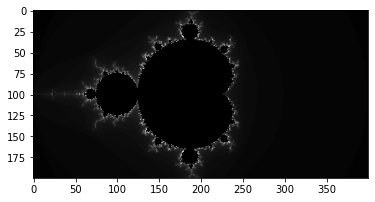

In [3]:
def find_iter(cx, cy, max_iter):
	zx, zy = 0.0, 0.0
	iter = 0
	while iter < max_iter and zx**2 + zy**2 < 4:
		iter += 1
		zx_old = zx
		zx = zx**2 - zy**2 + cx
		zy = 2*zx_old*zy + cy
	return iter

def render_numpy(width, height, max_iter):
    image = np.full((width, height, 3), [0,0,0], dtype=np.uint32)
    xcoords = np.linspace(-2, 2, width, dtype=np.float64)
    ycoords = np.linspace(-1, 1, height, dtype=np.float64)
    for x in range(width):
        for y in range(height):
            cx = xcoords[x]
            cy = ycoords[y]
            iter = find_iter(cx,cy,max_iter)
            col = 0 if iter == max_iter else int(iter / max_iter * 255)
            image[x,y] = [col,col,col]
    
    return image

image = render_numpy(400,200, max_iter=100)
plt.imshow(np.swapaxes(image, 0, 1))
# plt.savefig("mandelbrot-numpy", dpi=600) # Speichert das Ergebnis
plt.show()

Rendern das Mandelbrot mithilfe von Taichi

[W 03/14/24 12:06:41.676 83508] [cuda_driver.cpp:load_lib@36] libcuda.so lib not found.


[Taichi] Starting on arch=vulkan


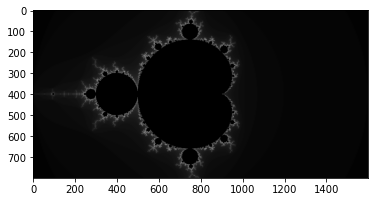

In [4]:
@ti.func
def find_iter_taichi(cx:ti.float64, cy:ti.float64, max_iter):
	zx, zy = 0.0, 0.0
	iter = 0
	while iter < max_iter and zx**2 + zy**2 < 4:
		iter += 1
		zx_old = zx
		zx = zx**2 - zy**2 + cx
		zy = 2*zx_old*zy + cy
	return iter

ti.init(arch=ti.gpu) # Benutz GPU als Backend
def render_taichi(width, height, max_iter):
	image_field = ti.Vector.field(n=3, shape=(width,height), dtype=ti.uint32)
	xcoords = np.linspace(-2,2,width)
	ycoords = np.linspace(-1,1,height)
	render_kernel(image_field, xcoords, ycoords, max_iter)
	return image_field.to_numpy()

@ti.kernel
def render_kernel(image_field:ti.template(), xcoords: ti.types.ndarray(), ycoords: ti.types.ndarray(), max_iter: int): # type:ignore
	for x,y in image_field: # paralellisiert
		cx = xcoords[x]
		cy = ycoords[y]
		iter = find_iter_taichi(cx,cy, max_iter)
		col = 0 if iter==max_iter else int(iter / max_iter *255)
		image_field[x,y] = [col,col,col]

# Der erster Lauf des Codes kann langsam sein
# Sequentielle Laeufe werden schneller
image = render_taichi(1600, 800, max_iter=100)
plt.imshow(np.swapaxes(image, 0, 1))
# plt.savefig("mandelbrot-taichi", dpi=600)
plt.show()

Rendern Mandelbrot mit Farbe

[Taichi] Starting on arch=vulkan


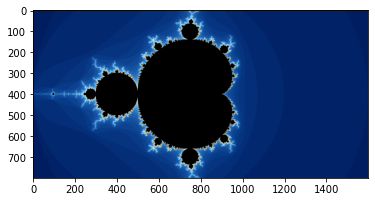

In [50]:
import taichi.math as tm
vec3 = ti.types.vector(3,float) #RGB vector type
@ti.func
def palette(t):
	a,b,c,d = vec3(0.5,0.5,0.5),vec3(0.5,0.5,0.5),vec3(1.0,1.0,1.0),vec3(0.5,0.60,0.70) # blueish scheme
	return a + b*tm.cos(6.28318*(c*t + d))

ti.init(arch=ti.gpu) # Benutz GPU als Backend
def render_color(width, height, max_iter):
	image_field = ti.Vector.field(n=3, shape=(width,height), dtype=ti.uint32)
	xcoords = np.linspace(-2,2,width)
	ycoords = np.linspace(-1,1,height)
	color_kernel(image_field, xcoords, ycoords, max_iter)
	return image_field.to_numpy()

@ti.kernel
def color_kernel(image_field:ti.template(), xcoords: ti.types.ndarray(), ycoords: ti.types.ndarray(), max_iter: int): # type:ignore
	for x,y in image_field: # paralellisiert
		cx = xcoords[x]
		cy = ycoords[y]
		iter = find_iter_taichi(cx,cy, max_iter)
		col = vec3(0) if iter==max_iter else int(palette(iter/max_iter) *255)
		image_field[x,y] = col

image = render_color(1600, 800, max_iter=100)
plt.imshow(np.swapaxes(image, 0, 1))
# plt.savefig("mandelbrot-color", dpi=600)
plt.show()

Rendern Mandelbrot mit kontinuierlichen Farbverläufen

[Taichi] Starting on arch=vulkan


[W 03/07/24 21:07:08.950 43553] 
File "/tmp/ipykernel_43553/1696911470.py", line 19, in smooth_kernel:
            zx = zx**2 - zy**2 + cx
            ^^^^^^^^^^^^^^^^^^^^^^^
Assign may lose precision: f32 <- f64
[W 03/07/24 21:07:08.950 43553] 
File "/tmp/ipykernel_43553/1696911470.py", line 20, in smooth_kernel:
            zy = 2*zx_old*zy + cy
            ^^^^^^^^^^^^^^^^^^^^^
Assign may lose precision: f32 <- f64
[W 03/07/24 21:07:08.950 43553] 
File "/tmp/ipykernel_43553/1696911470.py", line 26, in smooth_kernel:
        image_field[x,y] = col
        ^^^^^^^^^^^^^^^^^^^^^^
Assign may lose precision: u32 <- f32


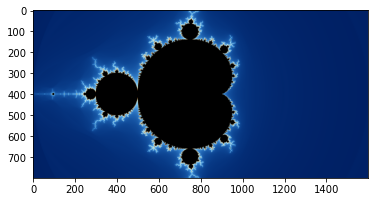

In [51]:
ti.init(arch=ti.gpu) # Benutz GPU als Backend
def render_smooth(width, height, max_iter):
	image_field = ti.Vector.field(n=3, shape=(width,height), dtype=ti.uint32)
	xcoords = np.linspace(-2,2,width)
	ycoords = np.linspace(-1,1,height)
	smooth_kernel(image_field, xcoords, ycoords, max_iter)
	return image_field.to_numpy()

@ti.kernel
def smooth_kernel(image_field:ti.template(), xcoords: ti.types.ndarray(), ycoords: ti.types.ndarray(), max_iter: int): # type:ignore
	for x,y in image_field: # paralellisiert
		cx = xcoords[x]
		cy = ycoords[y]
		zx, zy = 0.0, 0.0
		iter = 0
		
		while(zx**2 + zy**2 < 4 and iter < max_iter):
			zx_old = zx
			zx = zx**2 - zy**2 + cx
			zy = 2*zx_old*zy + cy
			iter += 1
		log_zn = tm.log(zx**2 + zy**2)/2
		nu = tm.log(log_zn / tm.log(2)) / tm.log(2)
		mu = iter + 1 - nu
		col = vec3(0) if iter == max_iter else int(palette(mu/max_iter)*255)
		image_field[x,y] = col

        
image = render_smooth(1600, 800, max_iter=100)
plt.imshow(np.swapaxes(image, 0, 1))
# plt.savefig("mandelbrot-smooth", dpi=600)
plt.show()